
-----------
## **Backtesting Optimization**

-----------

### **Introduction**
Evaluating **historical performance** to identify the **best asset allocations** that ***maximize portfolio returns***

----------

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns 

pd.options.display.float_format = '{:.2f}'.format



df = pd.read_csv(
    'Total Backtest 12H.csv',
    parse_dates=['EntryTime', 'ExitDate']
).dropna(subset=['return'])

df['PositionDuration'] = (df['ExitDate'] - df['EntryTime']).dt.total_seconds() / (12 * 3600)
df['PositionDuration'] = df['PositionDuration'].astype(int)
df['EntryTime'] = df['EntryTime'].dt.strftime('%Y-%m-%d')
df['ExitDate'] = df['ExitDate'].dt.strftime('%Y-%m-%d')

df = df[['slug', 'EntryTime', 'ExitDate', 'return', 'PositionDuration']]
df


,slug,EntryTime,ExitDate,return,PositionDuration
0,AAVE,2021-03-08,2021-03-11,-0.11,5
1,AAVE,2021-03-15,2021-03-31,-0.01,33
2,AAVE,2021-04-02,2021-04-07,-0.09,10
3,AAVE,2021-04-07,2021-04-12,-0.11,11
4,AAVE,2021-04-12,2021-04-18,-0.14,11
...,...,...,...,...,...
1976,XRP,2024-08-07,2024-08-27,-0.07,40
1977,XRP,2024-09-05,2024-09-16,-0.05,21
1978,XRP,2024-09-14,2024-09-17,-0.01,6
1979,XRP,2024-09-18,2024-10-02,-0.06,28



---

### 🟠**Parameters**

1. **Number of Assets**:
   - Let $n$ be the number of unique assets in the portfolio.
   - These assets are represented as:
     $$
     A = (A_1, A_2, \dots, A_n)
     $$

2. **Historical Time Periods**:
   - Let $T$ be the total number of historical periods for which data is available.



---

In [2]:
def assets_vector(df, asset_column):
    unique_assets = df[asset_column].unique().tolist()
    num_assets = len(unique_assets)
    return num_assets, unique_assets

def filtering_date(df, slug_column, time_column, threshold):
    """
    Filter the dataset to keep only slugs with more than 'threshold' historical periods.
    """
    num_periods_per_slug = time_periods(df, slug_column, time_column)
    valid_slugs = num_periods_per_slug[num_periods_per_slug > threshold].index
    filtered_df = df[df[slug_column].isin(valid_slugs)]
    return filtered_df

def time_periods(df, slug_column, time_column):
    df[time_column] = pd.to_datetime(df[time_column])
    num_periods_per_slug = df.groupby(slug_column)[time_column].nunique()
    return num_periods_per_slug



filtered_df = filtering_date(df.copy(), 'slug', 'EntryTime', 60)
num_periods_per_slug = time_periods(filtered_df, 'slug', 'EntryTime')
num_assets, assets = assets_vector(filtered_df, 'slug')

print('--'*90)

print(f"Number of Assets: \n-   {num_assets} \n-  Assets: {assets}")

print('--'*90)

filtered_df

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Assets: 
-   9 
-  Assets: ['AAVE', 'ATOM', 'BCH', 'ETC', 'FET', 'LINK', 'LTC', 'SOL', 'XRP']
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


,slug,EntryTime,ExitDate,return,PositionDuration
0,AAVE,2021-03-08,2021-03-11,-0.11,5
1,AAVE,2021-03-15,2021-03-31,-0.01,33
2,AAVE,2021-04-02,2021-04-07,-0.09,10
3,AAVE,2021-04-07,2021-04-12,-0.11,11
4,AAVE,2021-04-12,2021-04-18,-0.14,11
...,...,...,...,...,...
1976,XRP,2024-08-07,2024-08-27,-0.07,40
1977,XRP,2024-09-05,2024-09-16,-0.05,21
1978,XRP,2024-09-14,2024-09-17,-0.01,6
1979,XRP,2024-09-18,2024-10-02,-0.06,28



----------
1.  We use **Cumulative Return** Of the Assets Strategy where has Backtested , if we Assume the **Initial Investement** is *(1000 $)*

---------

In [3]:
filtered_df['EntryTime'] = pd.to_datetime(filtered_df['EntryTime'], errors='coerce')
def resample_weekly_returns(df, date_col='EntryTime', return_col='return'):
    resampled_data = []
    for slug, group in df.groupby('slug'):
        group = group.set_index(date_col)
        weekly_group = (
            group.resample('W-SAT', label='left', closed='left')[return_col].sum().reset_index()
        )
        weekly_group['slug'] = slug
        resampled_data.append(weekly_group)
    return pd.concat(resampled_data, ignore_index=True)

weekly_resampled_df = resample_weekly_returns(filtered_df, date_col='EntryTime', return_col='return')

print("\nWeekly Resampled Data (starting on Satureday):")
weekly_resampled_df



Weekly Resampled Data (starting on Satureday):


,EntryTime,return,slug
0,2021-03-06,-0.11,AAVE
1,2021-03-13,-0.01,AAVE
2,2021-03-20,0.00,AAVE
3,2021-03-27,-0.09,AAVE
4,2021-04-03,-0.11,AAVE
...,...,...,...
1676,2024-08-31,-0.05,XRP
1677,2024-09-07,0.00,XRP
1678,2024-09-14,-0.07,XRP
1679,2024-09-21,0.00,XRP


**Make a Portfolio where we allocate all the Deposits (1000 $) in a single Asset Based on the Strategy**

In [4]:
weekly_resampled_df['CumulativeReturn'] = weekly_resampled_df.groupby('slug')['return'].transform(lambda x: (1 + x).cumprod() - 1)
initial_investment = 1000
weekly_resampled_df['PortfolioValue'] = initial_investment * (1 + weekly_resampled_df['CumulativeReturn'])
weekly_resampled_df

,EntryTime,return,slug,CumulativeReturn,PortfolioValue
0,2021-03-06,-0.11,AAVE,-0.11,893.62
1,2021-03-13,-0.01,AAVE,-0.11,888.79
2,2021-03-20,0.00,AAVE,-0.11,888.79
3,2021-03-27,-0.09,AAVE,-0.19,809.68
4,2021-04-03,-0.11,AAVE,-0.28,724.28
...,...,...,...,...,...
1676,2024-08-31,-0.05,XRP,-0.82,178.19
1677,2024-09-07,0.00,XRP,-0.82,178.19
1678,2024-09-14,-0.07,XRP,-0.83,165.91
1679,2024-09-21,0.00,XRP,-0.83,165.91


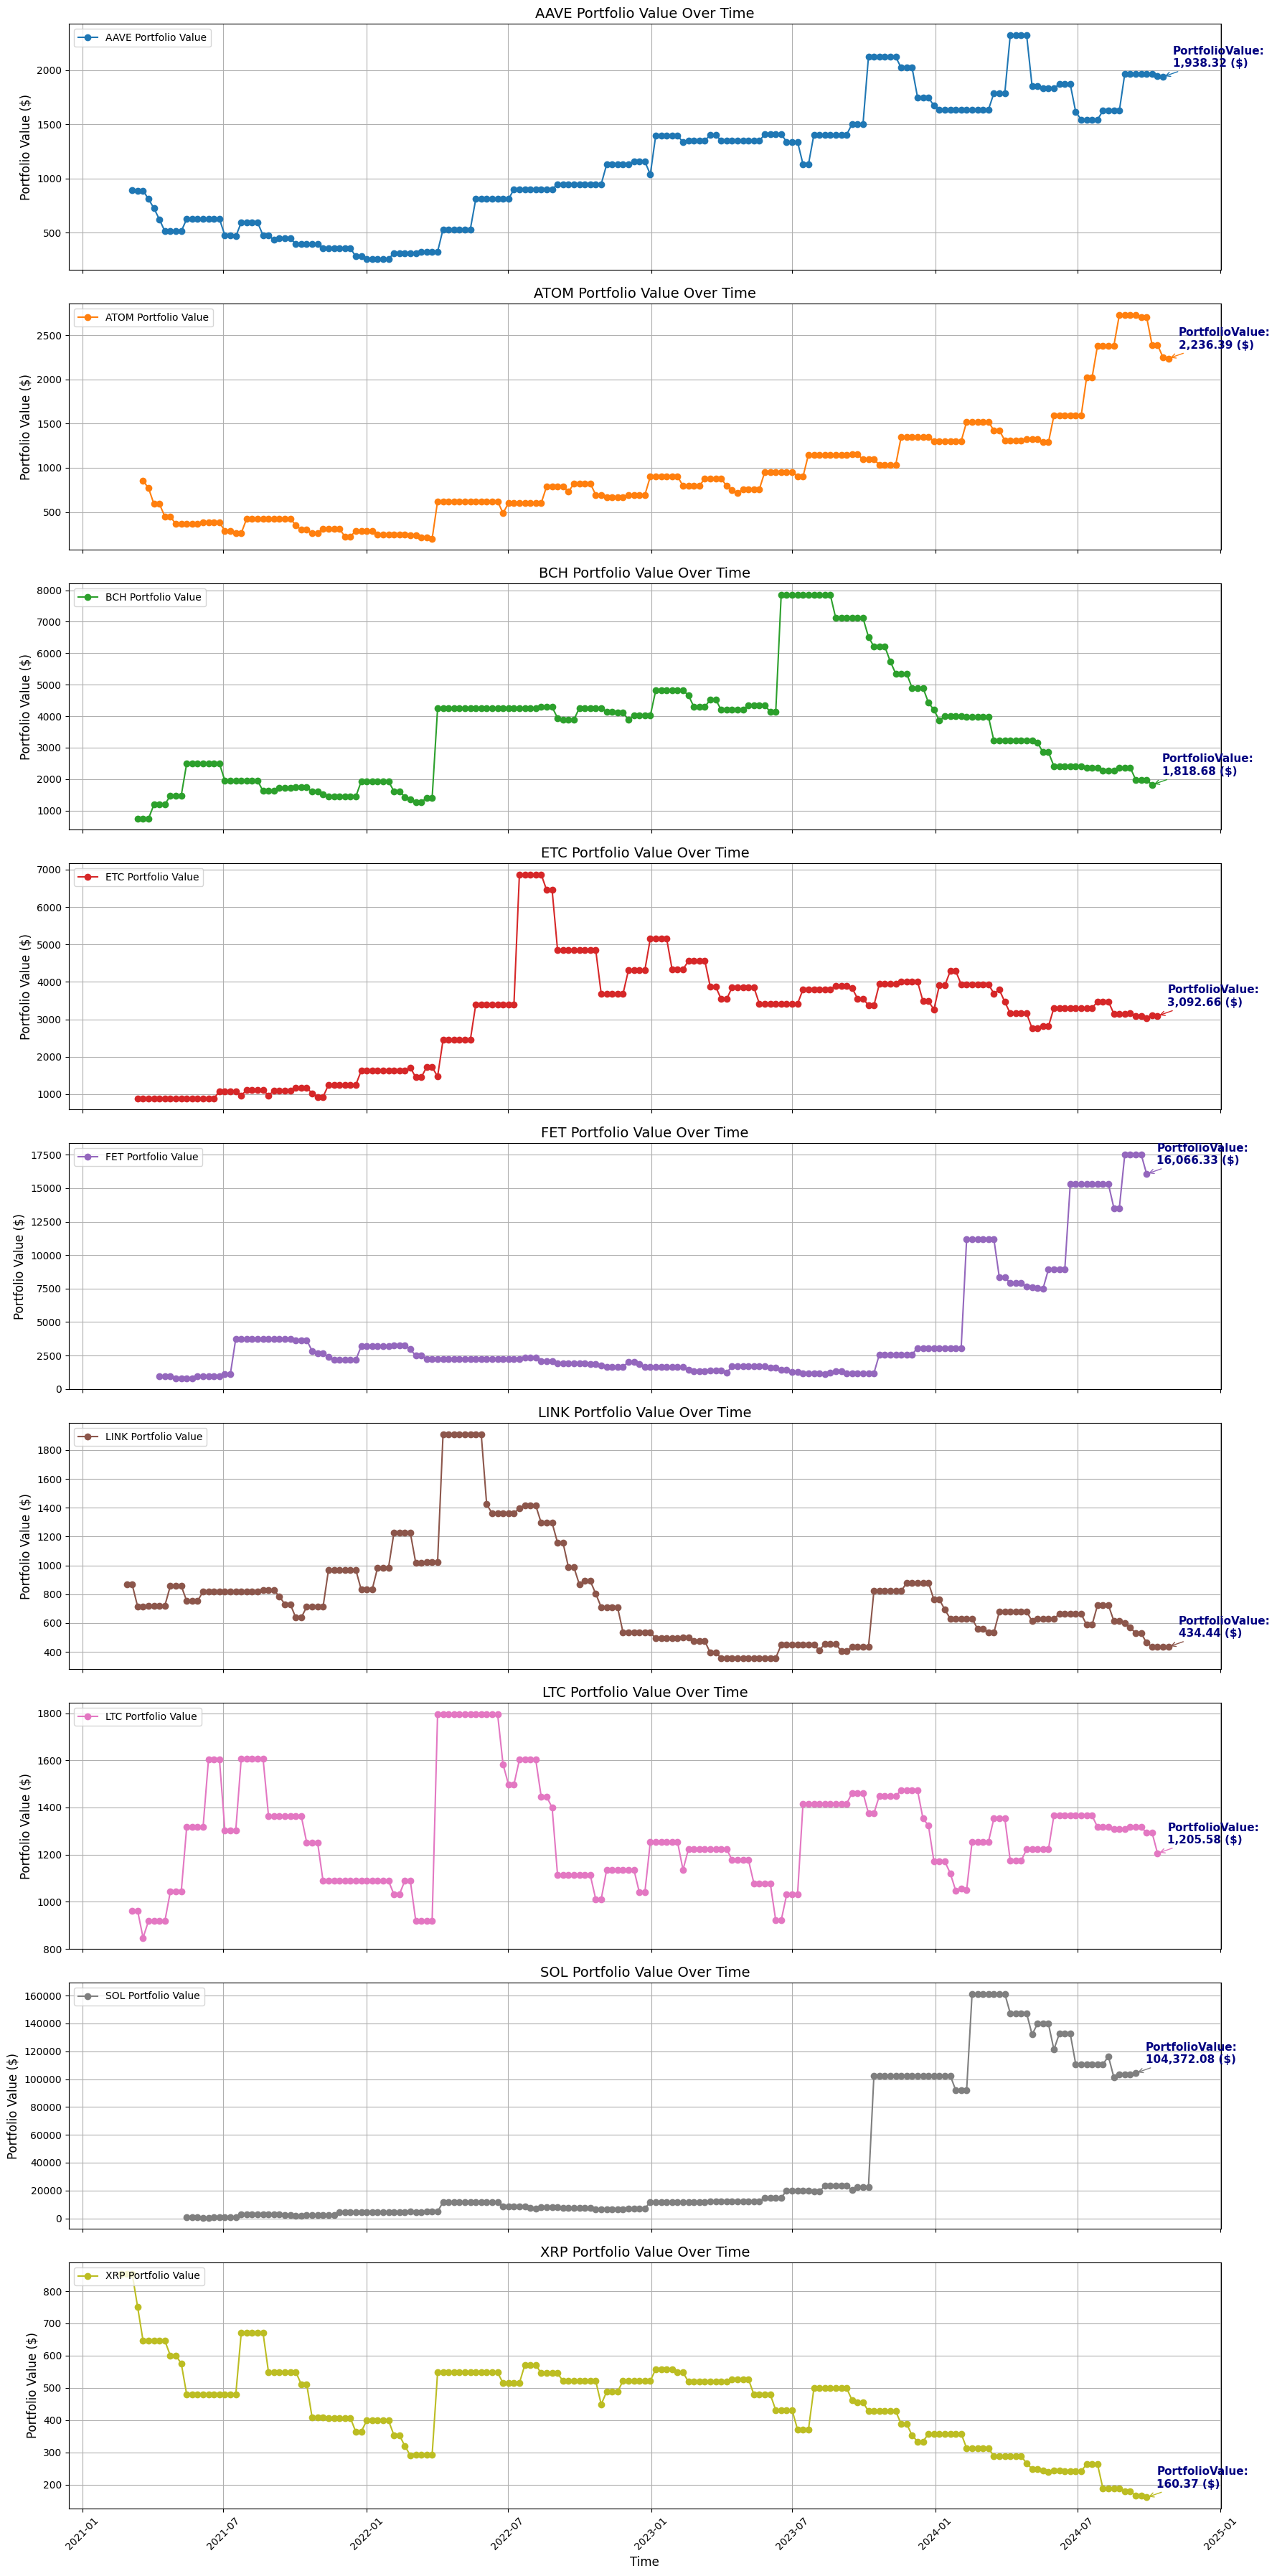

In [5]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
weekly_resampled_df['EntryTime'] = pd.to_datetime(weekly_resampled_df['EntryTime'], format='%Y-%m-%d', errors='coerce')
unique_assets = weekly_resampled_df['slug'].unique()
n_assets = len(unique_assets)
colors = colormaps.get_cmap('tab10')
fig, axes = plt.subplots(n_assets, 1, figsize=(18, 4 * n_assets), sharex=True)
if n_assets == 1:
    axes = [axes]

for idx, asset in enumerate(unique_assets):
    ax = axes[idx]
    asset_df = weekly_resampled_df[weekly_resampled_df['slug'] == asset]
    color = colors(idx / n_assets)
    ax.plot(
        asset_df['EntryTime'], asset_df['PortfolioValue'], marker='o', linestyle='-', 
        label=f'{asset} Portfolio Value', color=color
    )
    ax.set_title(f'{asset} Portfolio Value Over Time', fontsize=14)
    ax.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax.grid(True)
    ax.legend(loc='upper left', fontsize=10)
    
    final_value = asset_df['PortfolioValue'].iloc[-1]
    final_time = asset_df['EntryTime'].iloc[-1]
    ax.annotate(
        f'PortfolioValue:\n{final_value:,.2f} ($)',
        xy=(final_time, final_value),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=11,
        color='navy',  # Set text color to blue
        fontweight='bold',  # Set text font to bold
        arrowprops=dict(arrowstyle='->', color=color)
    )

# Set common x-axis label
axes[-1].set_xlabel('Time', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


3. **Returns Matrix**:
   - The returns matrix $R$ captures the historical returns of all assets across all time periods:
     $$
     R \in \mathbb{R}^{T \times n}
     $$

   Where:
   - $R_{t,i}$: The historical return of asset $A_i$ at time $t$.
   - Each **row** corresponds to a time period $t$.
   - Each **column** corresponds to an asset $A_i$.


   The Returns Matrix $R$ can be represented as:
   $$
   R =
   \begin{bmatrix}
   r_{1,1} & r_{1,2} & \cdots & r_{1,n} \\
   r_{2,1} & r_{2,2} & \cdots & r_{2,n} \\
   \vdots  & \vdots  & \ddots & \vdots  \\
   r_{T,1} & r_{T,2} & \cdots & r_{T,n}
   \end{bmatrix}
   $$

   For specific assets like BTC, ETH, and ADA, the matrix becomes:
   $$
   R =
   \begin{bmatrix}
   r_{t1, \text{BTC}} & r_{t1, \text{ETH}} & r_{t1, \text{ADA}} \\
   r_{t2, \text{BTC}} & r_{t2, \text{ETH}} & r_{t2, \text{ADA}} \\
   r_{t3, \text{BTC}} & r_{t3, \text{ETH}} & r_{t3, \text{ADA}} \\
   r_{t4, \text{BTC}} & r_{t4, \text{ETH}} & r_{t4, \text{ADA}}
   \end{bmatrix}
   $$

   Where:
   - $r_{t1, \text{BTC}}$: Return of BTC at time $t1$.
   - $r_{t1, \text{ETH}}$: Return of ETH at time $t1$.
   - $r_{t1, \text{ADA}}$: Return of ADA at time $t1$.
   - Similarly, $t2$, $t3$, and $t4$ represent subsequent time periods.

In [6]:
return_matrix = weekly_resampled_df.pivot_table(
    index='EntryTime',
    columns='slug',
    values='return',
)
valid_dates = return_matrix.dropna().index
filtered_weekly_df = weekly_resampled_df[weekly_resampled_df['EntryTime'].isin(valid_dates)]
filtered_weekly_df = filtered_weekly_df[~filtered_weekly_df['slug'].isin(['FET','SOL'])]

final_return_matrix = filtered_weekly_df.pivot_table(
    index='EntryTime',
    columns='slug',
    values='return',
    fill_value=0
)

print("Return Matrix:\n")
final_return_matrix

Return Matrix:



slug,AAVE,ATOM,BCH,ETC,LINK,LTC,XRP
EntryTime,,,,,,,
2021-05-15,0.22,0.00,0.69,0.00,-0.12,0.26,-0.17
2021-05-22,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2021-05-29,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2021-06-05,0.00,0.05,0.00,0.00,0.09,0.00,0.00
2021-06-12,0.00,0.00,0.00,0.00,0.00,0.22,0.00
...,...,...,...,...,...,...,...
2024-08-17,0.00,0.00,0.00,-0.09,-0.15,-0.01,0.00
2024-08-24,0.00,0.15,0.04,0.00,0.00,0.00,0.00
2024-08-31,0.21,0.00,0.00,0.00,-0.03,0.00,-0.05


In [7]:
final_return_matrix.isnull().sum()



slug
AAVE    0
ATOM    0
BCH     0
ETC     0
LINK    0
LTC     0
XRP     0
dtype: int64

**Covariance Matrix**


---

### 🟠**Maximizing Expected Return**

1. **Portfolio Return**:
   The portfolio return at time $t$ is given by:
   $$
   P_t = \sum_{i=1}^n w_i \cdot R_{t,i}
   $$

   Where:
   
   $
   w_i = [w_1, w_2, \dots, w_n]
   $
   represents the weights assigned to each asset.

2. **Cumulative Return**:
   The cumulative portfolio return over the entire period is:
   $$
   \text{Cumulative Return} = \prod_{t=1}^T (1 + P_t) - 1
   $$


---



**1.    Naive Asset Allocation (Base Model)**

Portfolio Weights for Each Asset:
slug
AAVE   0.14
ATOM   0.14
BCH    0.14
ETC    0.14
LINK   0.14
LTC    0.14
XRP    0.14
dtype: float64

Portfolio Value at the End of the Period: 
$3,038.40


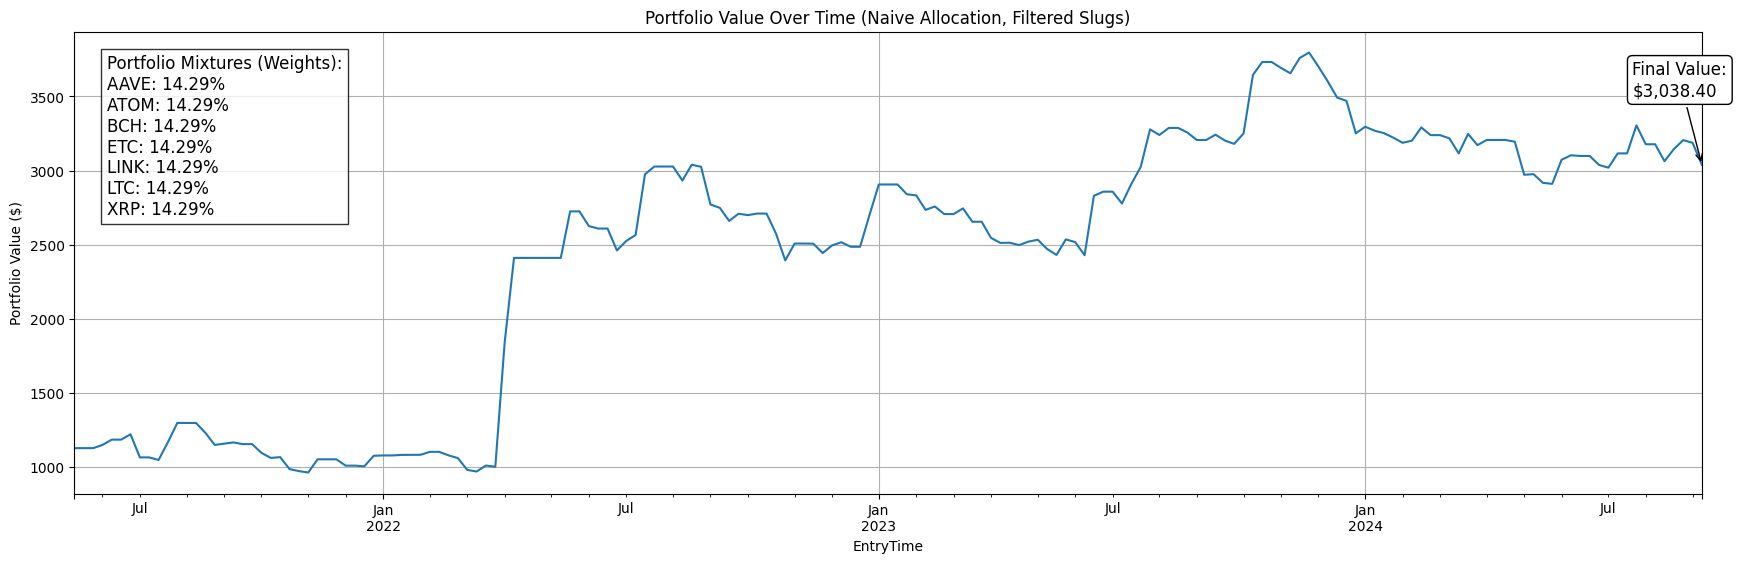

In [29]:
import matplotlib.pyplot as plt

n_assets = final_return_matrix.shape[1]
weights = np.full(n_assets, 1 / n_assets)
asset_weights = pd.Series(weights, index=final_return_matrix.columns)

print("Portfolio Weights for Each Asset:")
print(asset_weights)

portfolio_returns = final_return_matrix.dot(weights)
initial_investment = 1000
portfolio_value = initial_investment * (1 + portfolio_returns).cumprod()
portfolio_cumulative_return = (portfolio_value / initial_investment) - 1

final_portfolio_value = portfolio_value.iloc[-1]
final_date = portfolio_value.index[-1]
plt.figure(figsize=(21, 6))
portfolio_value.plot(
    title='Portfolio Value Over Time (Naive Allocation, Filtered Slugs)',
    ylabel='Portfolio Value ($)',
    grid=True
)

weights_text = "\n".join([f"{asset}: {weight:.2%}" for asset, weight in asset_weights.items()])
plt.text(
    x=0.02, y=0.95, s=f"Portfolio Mixtures (Weights):\n{weights_text}",
    transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8)
)
plt.annotate(
    f"Final Value:\n${final_portfolio_value:,.2f}",
    xy=(final_date, final_portfolio_value),  
    xytext=(-50, 50), textcoords='offset points', fontsize=12,
    bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'),
    arrowprops=dict(arrowstyle='->', color='black')
)

print(f"\nPortfolio Value at the End of the Period: \n${final_portfolio_value:,.2f}")
plt.show()
